
前 150 条高频共现边（格式：（词语1，词语2，共现频率））：
（人工，智能，154）
（协同，治理，55）
（智能，生成式，52）
（治理，风险，50）
（人工，生成式，49）
（企业，创新，47）
（优化，政策，42）
（中华，民族，40）
（数智，时代，37）
（新质，生产力，36）
（体系，构建，36）
（创新，技术，34）
（智能，治理，33）
（智能，风险，33）
（共同体，民族，33）
（优化，协同，33）
（智能，驱动，32）
（企业，效应，30）
（数据，驱动，30）
（基因，文化，28）
（数字，赋能，28）
（优化，驱动，27）
（数字，驱动，27）
（人工，治理，26）
（协同，驱动，26）
（城市，空间，26）
（乡村，振兴，25）
（安全，风险，25）
（数字，视域，25）
（创新，数字，25）
（构建，模型，25）
（优化，效应，25）
（政策，效应，25）
（干预，青少年，25）
（数字化，转型，24）
（实践，理论，24）
（中华，共同体，24）
（技术，数字，24）
（智能，赋能，24）
（创新，驱动，24）
（提升，韧性，24）
（企业，驱动，24）
（创新，政策，24）
（创新，网络，23）
（文化，视域，23）
（意识，民族，23）
（创新，赋能，23）
（传播，文化，23）
（文化，构建，23）
（模型，语言，23）
（技术，驱动，23）
（生态，系统，23）
（数据，模态，23）
（中华，文化，22）
（数字，机理，22）
（创新，智能，22）
（创新，协同，22）
（数字，治理，22）
（协同，智能，22）
（企业，优化，22）
（机理，治理，22）
（治理，社会，22）
（教育，职业，22）
（人工，风险，21）
（中国，文学，21）
（应用，构建，21）
（应用，智能，21）
（人机，协同，21）
（人工，驱动，21）
（企业，政策，21）
（企业，技术，21）
（治理，视域，20）
（优化，机理，20）
（识别，风险，20）
（大学生，干预，20）
（媒体，社交，20）
（人工，赋能，20）
（技术，智能，20）
（中国，传播，20）
（城市，治理，20）
（文化，认同，20）
（效应，治理，20）
（干预，认知，20）
（思想，教育，19）
（治理，驱动，19）
（形成，机理，19）
（时代，智能，19）


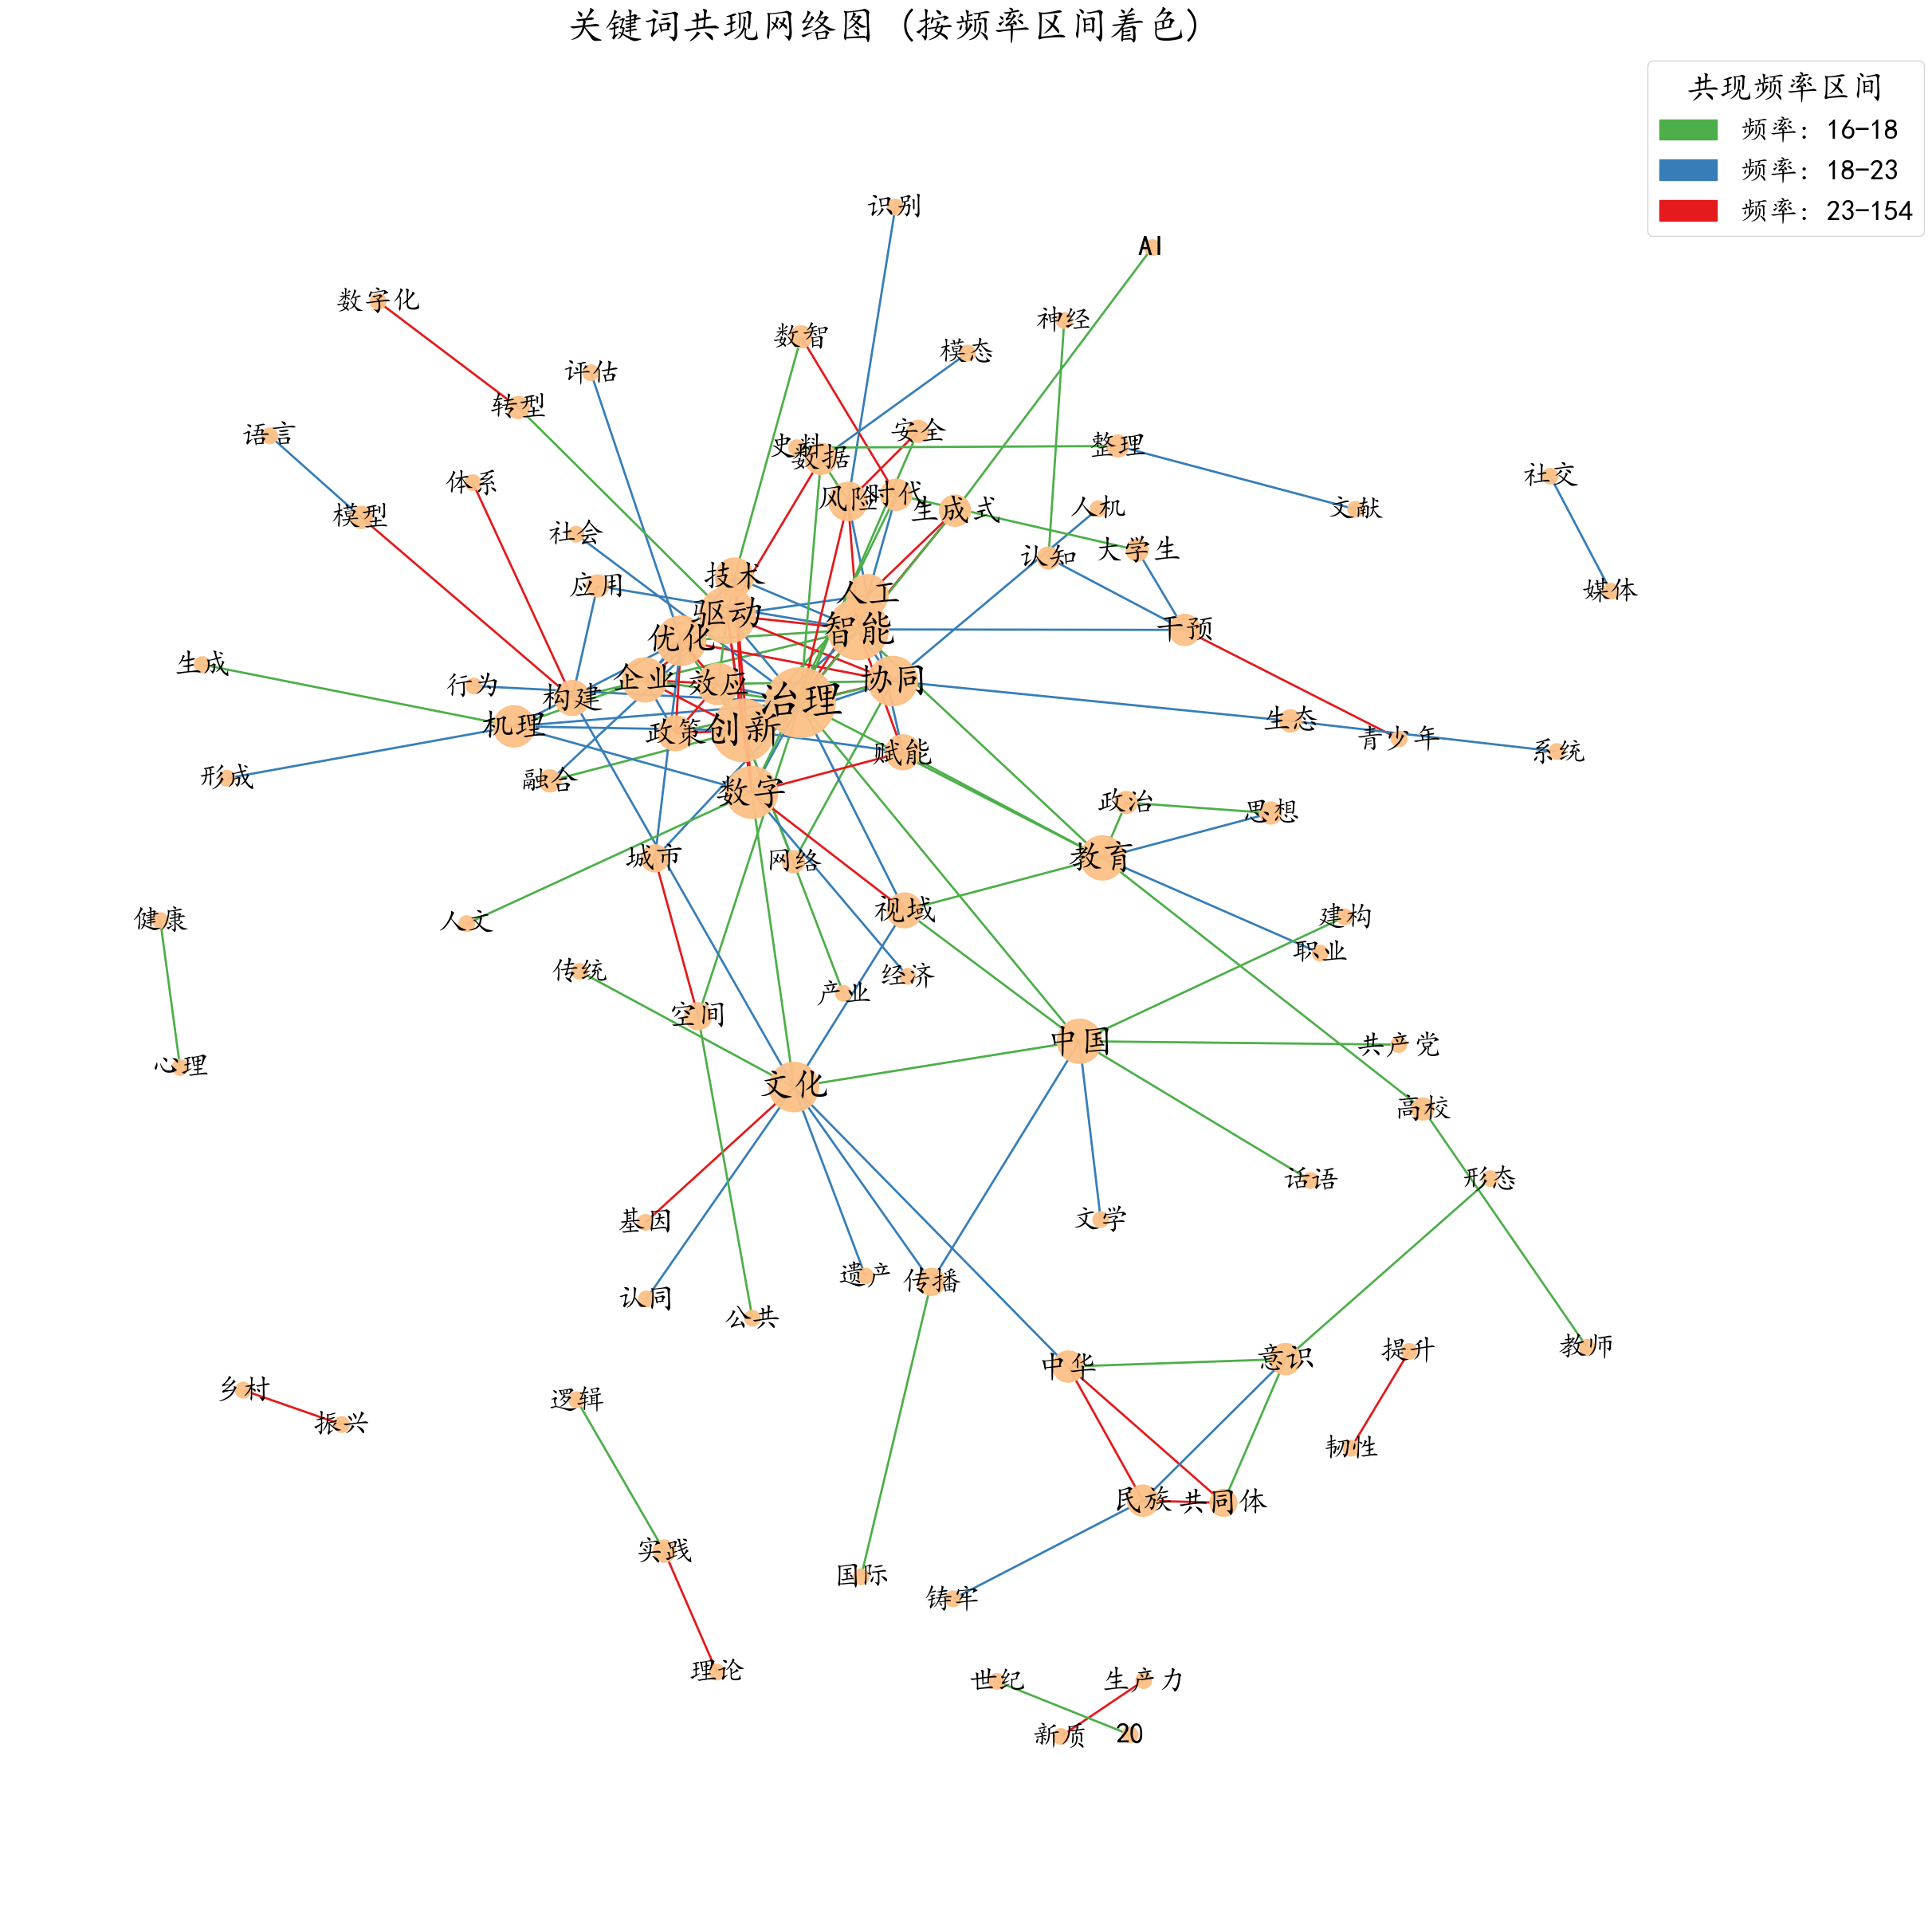

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from collections import Counter
from itertools import combinations
import numpy as np

# --- 参数与资源设置 ---
font_path = '/kaggle/input/fundings/simkai.ttf'
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 150
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 ---
df = pd.read_csv(csv_path)
# 修正列名为 '项目名称分词列'
df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)


# ===== 新增：打印 & 导出 TOP_K_EDGES =====
top_k_edges = co_occurrence_counts.most_common(TOP_K_EDGES)
if top_k_edges:
    print(f"\n前 {len(top_k_edges)} 条高频共现边（格式：（词语1，词语2，共现频率））：")
    for (w1, w2), c in top_k_edges:
        print(f"（{w1}，{w2}，{c}）")


G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 可视化网络图 ---
plt.figure(figsize=(24, 24)) 
pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)

node_degrees = dict(G.degree())
node_sizes = [v * 200 for v in node_degrees.values()]
NODE_COLOR = '#fdc086'

# --- 按频率区间为边分类并着色 ---
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]

try:
    categories, bins = pd.qcut(edge_weights, q=3, labels=False, retbins=True, duplicates='drop')
except ValueError:
    categories = [0] * len(edge_weights)
    bins = [min(edge_weights), max(edge_weights)]
    
color_palette = ['#4daf4a', '#377eb8', '#e41a1c'] 
edge_colors = [color_palette[cat] for cat in categories]

# 绘制节点和边
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=NODE_COLOR, alpha=0.95)
nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors) 

# --- 核心修改：将字号整合进FontProperties ---
# 为图例标题和条目分别创建包含了字号信息的字体对象
legend_title_font = FontProperties(fname=font_path, size=30)
legend_prop_font = FontProperties(fname=font_path, size=26)

legend_patches = []
for i in range(len(bins) - 1):
    label = f'频率: {int(bins[i])}-{int(bins[i+1])}'
    patch = mpatches.Patch(color=color_palette[i], label=label)
    legend_patches.append(patch)

# 移除冲突的fontsize和title_fontsize，使用新的字体对象
plt.legend(handles=legend_patches, 
           prop=legend_prop_font,          # <--- 使用包含字号的字体对象
           title="共现频率区间", 
           title_fontproperties=legend_title_font, # <--- 使用包含字号的字体对象
           loc='upper right',
           bbox_to_anchor=(1.1, 1.0))
# ------------------------------------

# --- 节点文字绘制 (无变动) ---
# 为节点文字创建总的字体对象
font_prop = FontProperties(fname=font_path)
MIN_FONT_SIZE, MAX_FONT_SIZE = 26, 40
min_degree, max_degree = min(node_degrees.values()), max(node_degrees.values())
if max_degree == min_degree:
    normalized_degrees = {node: 0.5 for node in node_degrees}
else:
    normalized_degrees = {
        node: (degree - min_degree) / (max_degree - min_degree)
        for node, degree in node_degrees.items()
    }

for node, (x, y) in pos.items():
    font_size = MIN_FONT_SIZE + normalized_degrees[node] * (MAX_FONT_SIZE - MIN_FONT_SIZE)
    plt.text(x, y, node, 
             fontproperties=font_prop, 
             fontsize=font_size, 
             ha='center', 
             va='center',
             fontweight='bold')

# --- 图表标题和保存 (无变动) ---
plt.title('关键词共现网络图 (按频率区间着色)', fontproperties=font_prop, fontsize=35)
plt.axis('off')
plt.tight_layout()

plt.savefig('keyword_co-occurrence_network_overall.png', dpi=300, bbox_inches='tight')
print("\n已修正图例字体错误的关键词共现网络图已保存为 'keyword_co-occurrence_network_overall.png'")


前 150 条高频共现边（格式：（词语1，词语2，共现频率））：
（人工，智能，32）
（企业，创新，29）
（企业，效应，18）
（创新，技术，16）
（企业，治理，14）
（优化，协同，13）
（企业，技术，13）
（协同，治理，13）
（企业，驱动，12）
（效应，治理，12）
（生态，系统，12）
（创新，数字，11）
（数据，驱动，11）
（创新，驱动，11）
（企业，数字，10）
（优化，政策，10）
（技术，驱动，10）
（信息，披露，9）
（企业，优化，9）
（优化，驱动，9）
（协同，驱动，9）
（机理，治理，9）
（价值，数字，8）
（治理，风险，8）
（企业，制造，8）
（数字，驱动，8）
（技术，突破，8）
（创新，机理，8）
（协同，效应，8）
（治理，行为，8）
（技术，治理，8）
（优化，效应，8）
（创新，效应，8）
（提升，韧性，8）
（优化，平台，8）
（数字化，转型，8）
（企业，政策，8）
（技术，数字，7）
（优化，决策，7）
（企业，资源，7）
（技术，效应，7）
（协同，政策，7）
（协同，系统，7）
（企业，提升，7）
（机理，驱动，7）
（转型，驱动，7）
（产业，融合，7）
（双碳，目标，7）
（供应链，协同，7）
（双刃剑，效应，7）
（产业，创新，7）
（数据，机理，7）
（价值，企业，6）
（企业，形成，6）
（优化，供应链，6）
（价值，生态，6）
（动态，演化，6）
（企业，平台，6）
（治理，驱动，6）
（企业，经济，6）
（后果，经济，6）
（动态，数据，6）
（网络，韧性，6）
（韧性，风险，6）
（数据，风险，6）
（供应链，治理，6）
（价值，数据，6）
（创新，创新，6）
（融合，驱动，6）
（人工，驱动，6）
（形成，治理，6）
（智能，驱动，6）
（供应链，电商，6）
（智能，消费者，6）
（企业，机理，6）
（数字，生态，6）
（动态，协同，6）
（政策，评估，6）
（企业，核心，6）
（企业，溢出，6）
（优化，创新，6）
（关键，技术，6）
（创新，网络，6）
（创新，生态，6）
（创新，系统，6）
（优化，运营，6）
（平台，运营，6）
（优化，机理，6）
（协同，技术，6）
（企业，作用，6）
（优化，系统，6）
（决策，协同，6）
（创新，政策，6）
（效应，评估，6）
（技

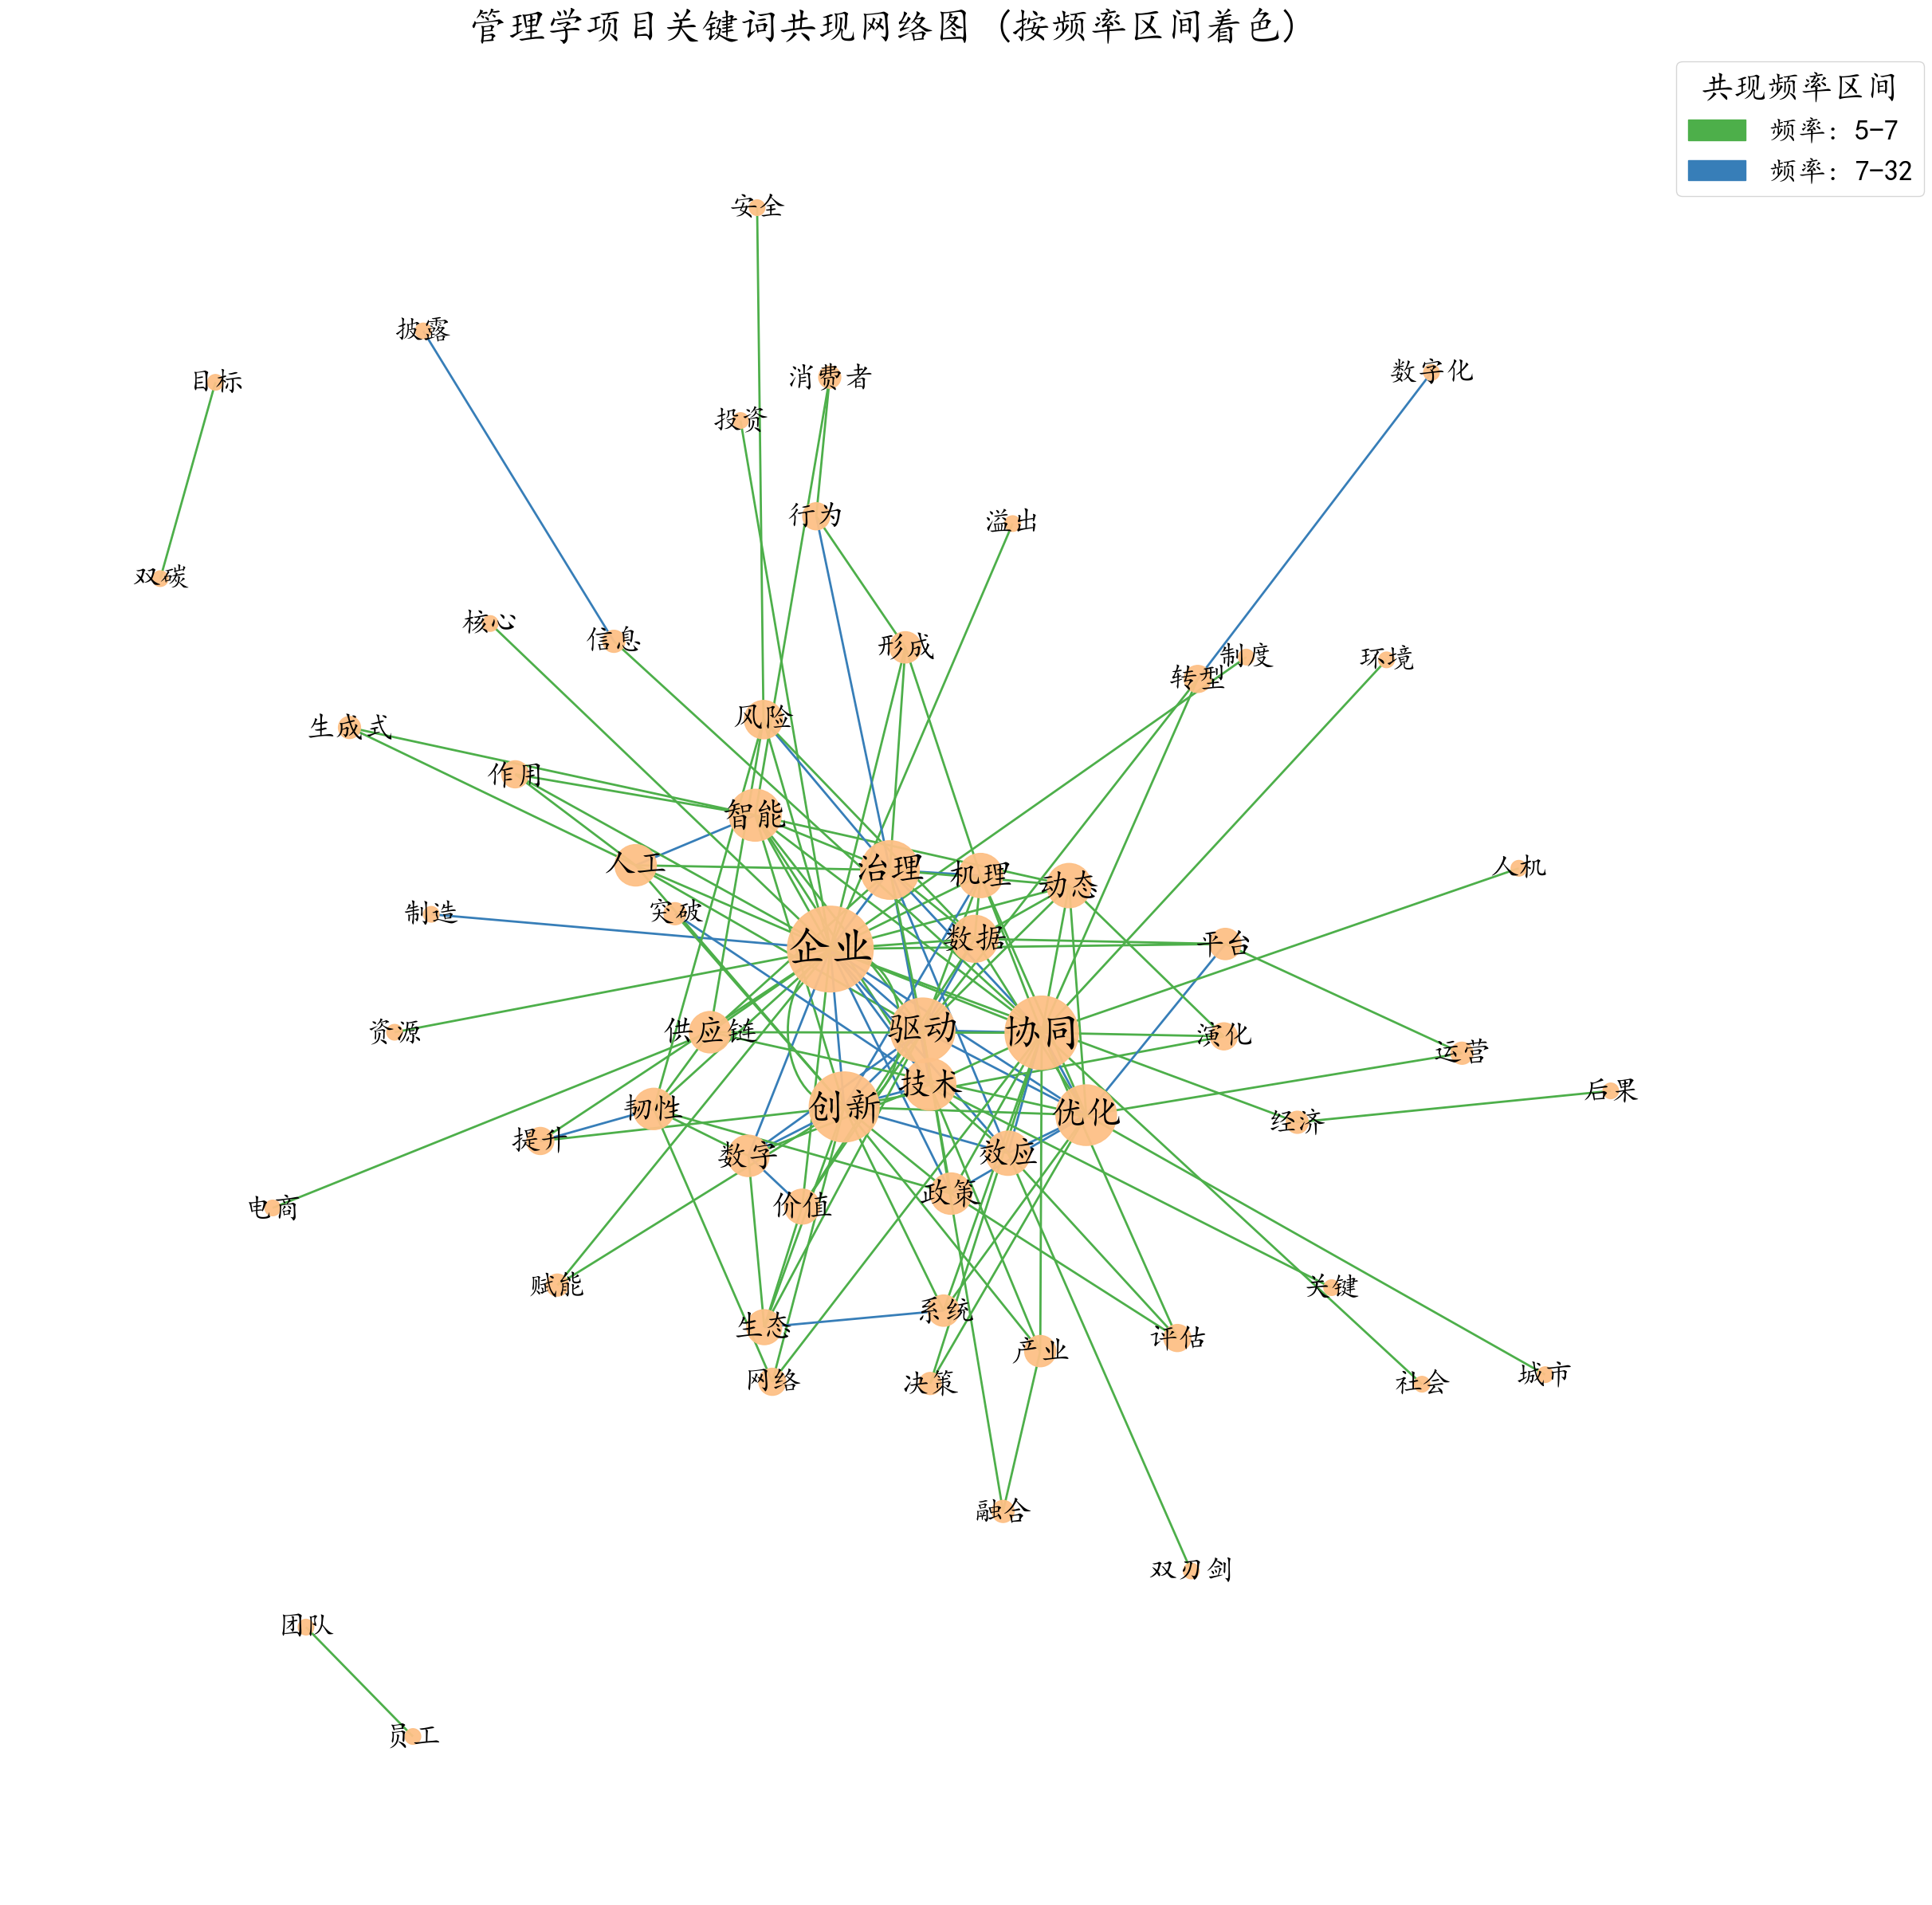

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from collections import Counter
from itertools import combinations
import numpy as np

# --- 参数与资源设置 ---
font_path = '/kaggle/input/fundings/simkai.ttf'
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 150
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 ---
df = pd.read_csv(csv_path)
df = df[df['学科门类'] == '管理学'].copy()

# 修正列名为 '项目名称分词列'
df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)


# ===== 新增：打印 & 导出 TOP_K_EDGES =====
top_k_edges = co_occurrence_counts.most_common(TOP_K_EDGES)
if top_k_edges:
    print(f"\n前 {len(top_k_edges)} 条高频共现边（格式：（词语1，词语2，共现频率））：")
    for (w1, w2), c in top_k_edges:
        print(f"（{w1}，{w2}，{c}）")


G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 可视化网络图 ---
plt.figure(figsize=(24, 24)) 
pos = nx.spring_layout(G, k=0.9, iterations=50, seed=42)

node_degrees = dict(G.degree())
node_sizes = [v * 200 for v in node_degrees.values()]
NODE_COLOR = '#fdc086'

# --- 按频率区间为边分类并着色 ---
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]

try:
    categories, bins = pd.qcut(edge_weights, q=3, labels=False, retbins=True, duplicates='drop')
except ValueError:
    categories = [0] * len(edge_weights)
    bins = [min(edge_weights), max(edge_weights)]
    
color_palette = ['#4daf4a', '#377eb8', '#e41a1c'] 
edge_colors = [color_palette[cat] for cat in categories]

# 绘制节点和边
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=NODE_COLOR, alpha=0.95)
nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors) 

# --- 核心修改：将字号整合进FontProperties ---
# 为图例标题和条目分别创建包含了字号信息的字体对象
legend_title_font = FontProperties(fname=font_path, size=30)
legend_prop_font = FontProperties(fname=font_path, size=26)

legend_patches = []
for i in range(len(bins) - 1):
    label = f'频率: {int(bins[i])}-{int(bins[i+1])}'
    patch = mpatches.Patch(color=color_palette[i], label=label)
    legend_patches.append(patch)

# 移除冲突的fontsize和title_fontsize，使用新的字体对象
plt.legend(handles=legend_patches, 
           prop=legend_prop_font,          # <--- 使用包含字号的字体对象
           title="共现频率区间", 
           title_fontproperties=legend_title_font, # <--- 使用包含字号的字体对象
           loc='upper right',
           bbox_to_anchor=(1.1, 1.0))
# ------------------------------------

# --- 节点文字绘制 (无变动) ---
# 为节点文字创建总的字体对象
font_prop = FontProperties(fname=font_path)
MIN_FONT_SIZE, MAX_FONT_SIZE = 26, 40
min_degree, max_degree = min(node_degrees.values()), max(node_degrees.values())
if max_degree == min_degree:
    normalized_degrees = {node: 0.5 for node in node_degrees}
else:
    normalized_degrees = {
        node: (degree - min_degree) / (max_degree - min_degree)
        for node, degree in node_degrees.items()
    }

for node, (x, y) in pos.items():
    font_size = MIN_FONT_SIZE + normalized_degrees[node] * (MAX_FONT_SIZE - MIN_FONT_SIZE)
    plt.text(x, y, node, 
             fontproperties=font_prop, 
             fontsize=font_size, 
             ha='center', 
             va='center',
             fontweight='bold')

# --- 图表标题和保存 (无变动) ---
plt.title('管理学项目关键词共现网络图 (按频率区间着色)', fontproperties=font_prop, fontsize=35)
plt.axis('off')
plt.tight_layout()

plt.savefig('keyword_co-occurrence_network_management.png', dpi=300, bbox_inches='tight')
print("\n已修正图例字体错误的关键词共现网络图已保存为 'keyword_co-occurrence_network_management.png'")


前 150 条高频共现边（格式：（词语1，词语2，共现频率））：
（人工，智能，38）
（协同，治理，22）
（城市，空间，19）
（治理，风险，19）
（人工，生成式，17）
（智能，治理，17）
（智能，生成式，17）
（智能，风险，16）
（数据，驱动，14）
（干预，青少年，13）
（人工，治理，13）
（智能，驱动，13）
（识别，风险，13）
（数据，模态，13）
（优化，协同，12）
（治理，社会，11）
（治理，韧性，11）
（公共，空间，11）
（文化，视域，10）
（媒体，社交，10）
（城市，治理，10）
（提升，韧性，10）
（协同，智能，10）
（安全，风险，10）
（优化，城市，10）
（提升，评估，10）
（干预，模态，9）
（模态，驱动，9）
（治理，生成式，9）
（治理，空间，9）
（协同，驱动，9）
（交互，设计，9）
（协同，数据，9）
（数据，治理，9）
（多源，数据，9）
（治理，驱动，9）
（韧性，风险，9）
（数据，智能，9）
（健康，心理，9）
（干预，认知，9）
（老年，认知，9）
（防控，风险，9）
（协同，网络，8）
（叙事，文化，8）
（优化，驱动，8）
（网络，韧性，8）
（传统，文化，8）
（空间，驱动，8）
（新质，生产力，8）
（创新，协同，8）
（体系，构建，8）
（人文，数字，8）
（智能，赋能，8）
（优化，数据，8）
（数据，融合，8）
（乡村，振兴，8）
（城市，驱动，8）
（优化，评估，8）
（数据，风险，8）
（决策，智能，8）
（学习，干预，7）
（数字，构建，7）
（创新，治理，7）
（干预，数字，7）
（城市，韧性，7）
（协同，空间，7）
（社区，空间，7）
（文化，遗产，7）
（干预，心理，7）
（技术，驱动，7）
（中国，传播，7）
（文化，构建，7）
（协同，风险，7）
（构建，模型，7）
（预警，风险，7）
（数字，老年人，7）
（健康，数字，7）
（协同，设计，7）
（数字，视域，7）
（健康，行为，7）
（数字，驱动，7）
（传统，村落，7）
（大学生，干预，7）
（模态，融合，7）
（乡村，文化，7）
（传播，文化，7）
（儿童，干预，7）
（数字，文化，7）
（人工，风险，7）
（风险，驱动，7）
（协同，城市，7）
（优化，风险，6）
（学习，模态，6）
（协同

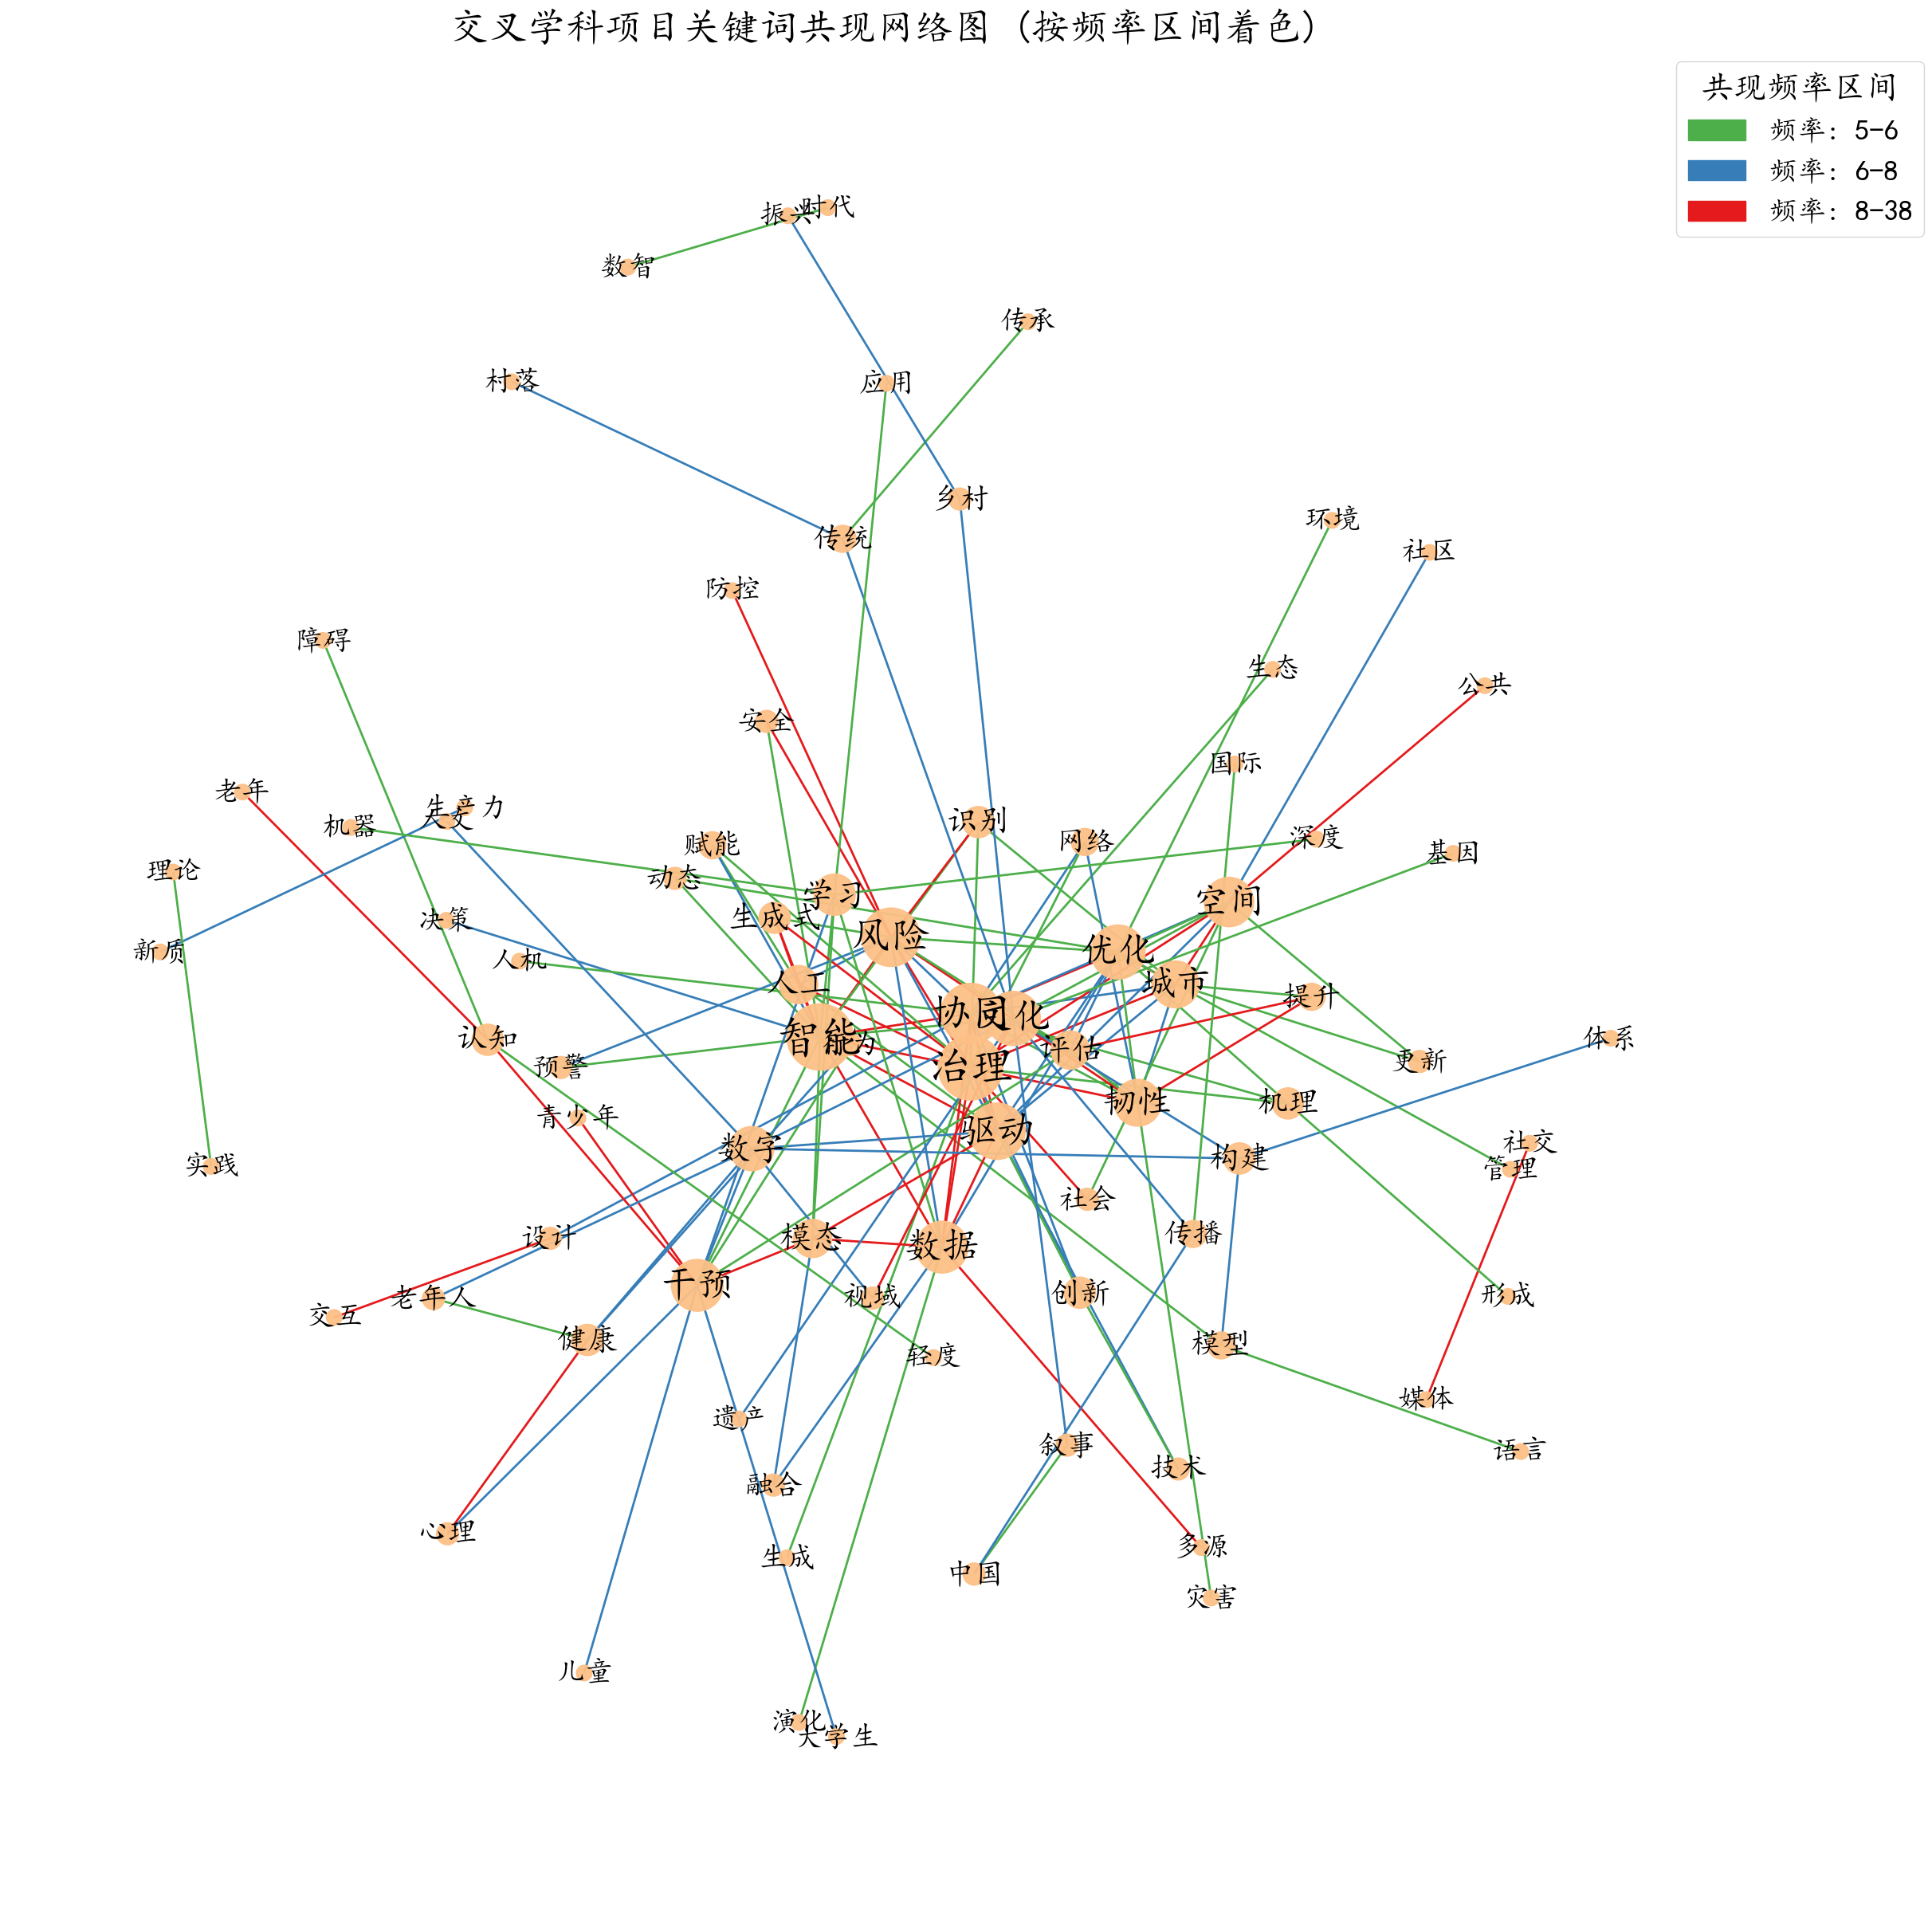

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
from collections import Counter
from itertools import combinations
import numpy as np

# --- 参数与资源设置 ---
font_path = '/kaggle/input/fundings/simkai.ttf'
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 150
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 ---
df = pd.read_csv(csv_path)
df = df[df['学科门类'] == '交叉学科/综合研究'].copy()

# 修正列名为 '项目名称分词列'
df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)


# ===== 新增：打印 & 导出 TOP_K_EDGES =====
top_k_edges = co_occurrence_counts.most_common(TOP_K_EDGES)
if top_k_edges:
    print(f"\n前 {len(top_k_edges)} 条高频共现边（格式：（词语1，词语2，共现频率））：")
    for (w1, w2), c in top_k_edges:
        print(f"（{w1}，{w2}，{c}）")


G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 可视化网络图 ---
plt.figure(figsize=(24, 24)) 
pos = nx.spring_layout(G, k=0.9, iterations=50, seed=44)

node_degrees = dict(G.degree())
node_sizes = [v * 200 for v in node_degrees.values()]
NODE_COLOR = '#fdc086'

# --- 按频率区间为边分类并着色 ---
edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]

try:
    categories, bins = pd.qcut(edge_weights, q=3, labels=False, retbins=True, duplicates='drop')
except ValueError:
    categories = [0] * len(edge_weights)
    bins = [min(edge_weights), max(edge_weights)]
    
color_palette = ['#4daf4a', '#377eb8', '#e41a1c'] 
edge_colors = [color_palette[cat] for cat in categories]

# 绘制节点和边
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=NODE_COLOR, alpha=0.95)
nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors) 

# --- 核心修改：将字号整合进FontProperties ---
# 为图例标题和条目分别创建包含了字号信息的字体对象
legend_title_font = FontProperties(fname=font_path, size=30)
legend_prop_font = FontProperties(fname=font_path, size=26)

legend_patches = []
for i in range(len(bins) - 1):
    label = f'频率: {int(bins[i])}-{int(bins[i+1])}'
    patch = mpatches.Patch(color=color_palette[i], label=label)
    legend_patches.append(patch)

# 移除冲突的fontsize和title_fontsize，使用新的字体对象
plt.legend(handles=legend_patches, 
           prop=legend_prop_font,          # <--- 使用包含字号的字体对象
           title="共现频率区间", 
           title_fontproperties=legend_title_font, # <--- 使用包含字号的字体对象
           loc='upper right',
           bbox_to_anchor=(1.1, 1.0))
# ------------------------------------

# --- 节点文字绘制 (无变动) ---
# 为节点文字创建总的字体对象
font_prop = FontProperties(fname=font_path)
MIN_FONT_SIZE, MAX_FONT_SIZE = 26, 40
min_degree, max_degree = min(node_degrees.values()), max(node_degrees.values())
if max_degree == min_degree:
    normalized_degrees = {node: 0.5 for node in node_degrees}
else:
    normalized_degrees = {
        node: (degree - min_degree) / (max_degree - min_degree)
        for node, degree in node_degrees.items()
    }

for node, (x, y) in pos.items():
    font_size = MIN_FONT_SIZE + normalized_degrees[node] * (MAX_FONT_SIZE - MIN_FONT_SIZE)
    plt.text(x, y, node, 
             fontproperties=font_prop, 
             fontsize=font_size, 
             ha='center', 
             va='center',
             fontweight='bold')

# --- 图表标题和保存 (无变动) ---
plt.title('交叉学科项目关键词共现网络图 (按频率区间着色)', fontproperties=font_prop, fontsize=35)
plt.axis('off')
plt.tight_layout()

plt.savefig('keyword_co-occurrence_network_cross.png', dpi=300, bbox_inches='tight')
print("\n已修正图例字体错误的关键词共现网络图已保存为 'keyword_co-occurrence_network_cross.png'")

In [4]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.2 MB/s eta 0:00:00:00:010:01


In [5]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as colors

# --- 准备工作 ---
# 如果您的环境中没有安装pyvis，请先运行此命令
# !pip install pyvis

# --- 参数与资源设置 (无变动) ---
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 1000
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 (无变动) ---
df = pd.read_csv(csv_path)
df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)

# 使用NetworkX构建基础图 (无变动)
G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 核心修改：使用Pyvis生成交互式网络图 ---

# 1. 初始化Pyvis网络图
# height和width可以自定义，bgcolor是背景色，font_color是字体颜色
net = Network(height='800px', width='100%', notebook=True, heading='关键词共现网络图 (交互版)', directed=False)

# 2. 为节点和边添加视觉属性
node_degrees = dict(G.degree())
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# 节点大小范围
MIN_NODE_SIZE = 15
MAX_NODE_SIZE = 50
min_degree = min(node_degrees.values())
max_degree = max(node_degrees.values())

# 连边宽度范围
MIN_EDGE_WIDTH = 1
MAX_EDGE_WIDTH = 10
min_weight = min(edge_weights)
max_weight = max(edge_weights)

# 3. 将NetworkX图的节点和属性添加到Pyvis图中
# 节点大小/字号范围
MIN_NODE_SIZE, MAX_NODE_SIZE = 30, 50
MIN_LABEL_SIZE, MAX_LABEL_SIZE = 12, 28  # ← 标签字号范围（可按需调大）

for node, degree in node_degrees.items():
    # 归一化得到圆圈大小
    if max_degree > min_degree:
        size = MIN_NODE_SIZE + (degree - min_degree) * (MAX_NODE_SIZE - MIN_NODE_SIZE) / (max_degree - min_degree)
    else:
        size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2

    # 关键：按“size”线性映射生成标签字号
    if MAX_NODE_SIZE > MIN_NODE_SIZE:
        label_size = MIN_LABEL_SIZE + (size - MIN_NODE_SIZE) * (MAX_LABEL_SIZE - MIN_LABEL_SIZE) / (MAX_NODE_SIZE - MIN_NODE_SIZE)
    else:
        label_size = (MIN_LABEL_SIZE + MAX_LABEL_SIZE) / 2

    net.add_node(
        node,
        size=size,
        label=node,  # 显式设置标签
        font={"size": int(label_size), "bold": True, "strokeWidth": 2, "strokeColor": "#ffffff"},  # ← 同步放大
        title=f"关键词: {node}\n连接数: {degree}",
        color="#f9c74f"
    )


# 4. 将NetworkX图的边和属性添加到Pyvis图中
for u, v, data in G.edges(data=True):
    weight = data['weight']

    # 归一化得到边宽
    if max_weight > min_weight:
        width = MIN_EDGE_WIDTH + (weight - min_weight) * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH) / (max_weight - min_weight)
    else:
        width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2

    # 关键：自定义提示文本（选中/悬停都会显示）
    # 形如：{词语A，词语B}贡献频率：8
    title_text = "{{{}}}共现频率：{}".format(f"{u}，{v}", weight)

    net.add_edge(
        u, v,
        width=width,
        value=weight,           # physics/缩放可用真实权重（建议用权重而非width）
        title=title_text        # ← 自定义提示
    )


net.set_options("""{
  "layout": { "improvedLayout": true },
  "interaction": { "hover": true, "tooltipDelay": 150 },
  "configure": { "enabled": true, "filter": ["physics"] },
  "physics": {
    "enabled": true,
    "solver": "barnesHut",
    "stabilization": { "enabled": true, "iterations": 1600, "updateInterval": 25, "fit": true },
    "timestep": 0.35,
    "maxVelocity": 20,
    "minVelocity": 0.75,
    "barnesHut": {
      "gravitationalConstant": -3800,
      "centralGravity": 0.28,
      "springLength": 135,
      "springConstant": 0.018,
      "damping": 0.72,
      "avoidOverlap": 0.25
    }
  }
}
""")



# 保存为HTML文件，您可以在任何浏览器中打开它
net.save_graph('interactive_keyword_network_overall.html')

print("\n动态交互式网络图已成功保存为 'interactive_keyword_network_overall.html'")
print("请在您的文件目录中找到该文件，并用浏览器打开以进行交互。")


动态交互式网络图已成功保存为 'interactive_keyword_network_overall.html'
请在您的文件目录中找到该文件，并用浏览器打开以进行交互。


In [6]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as colors

# --- 准备工作 ---
# 如果您的环境中没有安装pyvis，请先运行此命令
# !pip install pyvis

# --- 参数与资源设置 (无变动) ---
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 500
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 (无变动) ---
df = pd.read_csv(csv_path)
df = df[df['学科门类'] == '交叉学科/综合研究'].copy()

df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)

# 使用NetworkX构建基础图 (无变动)
G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 核心修改：使用Pyvis生成交互式网络图 ---

# 1. 初始化Pyvis网络图
# height和width可以自定义，bgcolor是背景色，font_color是字体颜色
net = Network(height='800px', width='100%', notebook=True, heading='关键词共现网络图 (交互版)', directed=False)

# 2. 为节点和边添加视觉属性
node_degrees = dict(G.degree())
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# 节点大小范围
MIN_NODE_SIZE = 15
MAX_NODE_SIZE = 50
min_degree = min(node_degrees.values())
max_degree = max(node_degrees.values())

# 连边宽度范围
MIN_EDGE_WIDTH = 1
MAX_EDGE_WIDTH = 10
min_weight = min(edge_weights)
max_weight = max(edge_weights)

# 3. 将NetworkX图的节点和属性添加到Pyvis图中
# 节点大小/字号范围
MIN_NODE_SIZE, MAX_NODE_SIZE = 30, 50
MIN_LABEL_SIZE, MAX_LABEL_SIZE = 12, 28  # ← 标签字号范围（可按需调大）

for node, degree in node_degrees.items():
    # 归一化得到圆圈大小
    if max_degree > min_degree:
        size = MIN_NODE_SIZE + (degree - min_degree) * (MAX_NODE_SIZE - MIN_NODE_SIZE) / (max_degree - min_degree)
    else:
        size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2

    # 关键：按“size”线性映射生成标签字号
    if MAX_NODE_SIZE > MIN_NODE_SIZE:
        label_size = MIN_LABEL_SIZE + (size - MIN_NODE_SIZE) * (MAX_LABEL_SIZE - MIN_LABEL_SIZE) / (MAX_NODE_SIZE - MIN_NODE_SIZE)
    else:
        label_size = (MIN_LABEL_SIZE + MAX_LABEL_SIZE) / 2

    net.add_node(
        node,
        size=size,
        label=node,  # 显式设置标签
        font={"size": int(label_size), "bold": True, "strokeWidth": 2, "strokeColor": "#ffffff"},  # ← 同步放大
        title=f"关键词: {node}\n连接数: {degree}",
        color="#f9c74f"
    )


# 4. 将NetworkX图的边和属性添加到Pyvis图中
for u, v, data in G.edges(data=True):
    weight = data['weight']

    # 归一化得到边宽
    if max_weight > min_weight:
        width = MIN_EDGE_WIDTH + (weight - min_weight) * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH) / (max_weight - min_weight)
    else:
        width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2

    # 关键：自定义提示文本（选中/悬停都会显示）
    # 形如：{词语A，词语B}贡献频率：8
    title_text = "{{{}}}共现频率：{}".format(f"{u}，{v}", weight)

    net.add_edge(
        u, v,
        width=width,
        value=weight,           # physics/缩放可用真实权重（建议用权重而非width）
        title=title_text        # ← 自定义提示
    )


net.set_options("""{
  "layout": { "improvedLayout": true },
  "interaction": { "hover": true, "tooltipDelay": 150 },
  "configure": { "enabled": true, "filter": ["physics"] },
  "physics": {
    "enabled": true,
    "solver": "barnesHut",
    "stabilization": { "enabled": true, "iterations": 1600, "updateInterval": 25, "fit": true },
    "timestep": 0.35,
    "maxVelocity": 20,
    "minVelocity": 0.75,
    "barnesHut": {
      "gravitationalConstant": -3800,
      "centralGravity": 0.28,
      "springLength": 135,
      "springConstant": 0.018,
      "damping": 0.72,
      "avoidOverlap": 0.25
    }
  }
}
""")



# 保存为HTML文件，您可以在任何浏览器中打开它
net.save_graph('interactive_keyword_network_cross.html')

print("\n动态交互式网络图已成功保存为 'interactive_keyword_network_cross.html'")
print("请在您的文件目录中找到该文件，并用浏览器打开以进行交互。")


动态交互式网络图已成功保存为 'interactive_keyword_network_cross.html'
请在您的文件目录中找到该文件，并用浏览器打开以进行交互。


In [7]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as colors

# --- 准备工作 ---
# 如果您的环境中没有安装pyvis，请先运行此命令
# !pip install pyvis

# --- 参数与资源设置 (无变动) ---
csv_path = '/kaggle/input/fundings/2025-jiaoyubu-fenci.csv'
TOP_K_EDGES = 500
custom_stopwords = {'研究', '基于', '视角', '模式', '背景', '问题', '影响', '策略', '建设', '发展', '机制', '路径','——'}

# --- 数据加载与网络构建 (无变动) ---
df = pd.read_csv(csv_path)
df = df[df['学科门类'] == '管理学'].copy()

df.dropna(subset=['项目名称分词'], inplace=True)
project_keywords_list = [text.split() for text in df['项目名称分词']]

co_occurrences = []
for keywords in project_keywords_list:
    keywords = [word for word in keywords if word not in custom_stopwords and len(word) > 1]
    for pair in combinations(sorted(keywords), 2):
        co_occurrences.append(pair)
co_occurrence_counts = Counter(co_occurrences)

# 使用NetworkX构建基础图 (无变动)
G = nx.Graph()
edges_to_add = [(word1, word2, {'weight': count}) 
                for (word1, word2), count in co_occurrence_counts.most_common(TOP_K_EDGES)]
G.add_edges_from(edges_to_add)

# --- 核心修改：使用Pyvis生成交互式网络图 ---

# 1. 初始化Pyvis网络图
# height和width可以自定义，bgcolor是背景色，font_color是字体颜色
net = Network(height='800px', width='100%', notebook=True, heading='关键词共现网络图 (交互版)', directed=False)

# 2. 为节点和边添加视觉属性
node_degrees = dict(G.degree())
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# 节点大小范围
MIN_NODE_SIZE = 15
MAX_NODE_SIZE = 50
min_degree = min(node_degrees.values())
max_degree = max(node_degrees.values())

# 连边宽度范围
MIN_EDGE_WIDTH = 1
MAX_EDGE_WIDTH = 10
min_weight = min(edge_weights)
max_weight = max(edge_weights)

# 3. 将NetworkX图的节点和属性添加到Pyvis图中
# 节点大小/字号范围
MIN_NODE_SIZE, MAX_NODE_SIZE = 30, 50
MIN_LABEL_SIZE, MAX_LABEL_SIZE = 12, 28  # ← 标签字号范围（可按需调大）

for node, degree in node_degrees.items():
    # 归一化得到圆圈大小
    if max_degree > min_degree:
        size = MIN_NODE_SIZE + (degree - min_degree) * (MAX_NODE_SIZE - MIN_NODE_SIZE) / (max_degree - min_degree)
    else:
        size = (MIN_NODE_SIZE + MAX_NODE_SIZE) / 2

    # 关键：按“size”线性映射生成标签字号
    if MAX_NODE_SIZE > MIN_NODE_SIZE:
        label_size = MIN_LABEL_SIZE + (size - MIN_NODE_SIZE) * (MAX_LABEL_SIZE - MIN_LABEL_SIZE) / (MAX_NODE_SIZE - MIN_NODE_SIZE)
    else:
        label_size = (MIN_LABEL_SIZE + MAX_LABEL_SIZE) / 2

    net.add_node(
        node,
        size=size,
        label=node,  # 显式设置标签
        font={"size": int(label_size), "bold": True, "strokeWidth": 2, "strokeColor": "#ffffff"},  # ← 同步放大
        title=f"关键词: {node}\n连接数: {degree}",
        color="#f9c74f"
    )


# 4. 将NetworkX图的边和属性添加到Pyvis图中
for u, v, data in G.edges(data=True):
    weight = data['weight']

    # 归一化得到边宽
    if max_weight > min_weight:
        width = MIN_EDGE_WIDTH + (weight - min_weight) * (MAX_EDGE_WIDTH - MIN_EDGE_WIDTH) / (max_weight - min_weight)
    else:
        width = (MIN_EDGE_WIDTH + MAX_EDGE_WIDTH) / 2

    # 关键：自定义提示文本（选中/悬停都会显示）
    # 形如：{词语A，词语B}贡献频率：8
    title_text = "{{{}}}共现频率：{}".format(f"{u}，{v}", weight)

    net.add_edge(
        u, v,
        width=width,
        value=weight,           # physics/缩放可用真实权重（建议用权重而非width）
        title=title_text        # ← 自定义提示
    )


net.set_options("""{
  "layout": { "improvedLayout": true },
  "interaction": { "hover": true, "tooltipDelay": 150 },
  "configure": { "enabled": true, "filter": ["physics"] },
  "physics": {
    "enabled": true,
    "solver": "barnesHut",
    "stabilization": { "enabled": true, "iterations": 1600, "updateInterval": 25, "fit": true },
    "timestep": 0.35,
    "maxVelocity": 20,
    "minVelocity": 0.75,
    "barnesHut": {
      "gravitationalConstant": -3800,
      "centralGravity": 0.28,
      "springLength": 135,
      "springConstant": 0.018,
      "damping": 0.72,
      "avoidOverlap": 0.25
    }
  }
}
""")



# 保存为HTML文件，您可以在任何浏览器中打开它
net.save_graph('interactive_keyword_network_management.html')

print("\n动态交互式网络图已成功保存为 'interactive_keyword_network_management.html'")
print("请在您的文件目录中找到该文件，并用浏览器打开以进行交互。")


动态交互式网络图已成功保存为 'interactive_keyword_network_management.html'
请在您的文件目录中找到该文件，并用浏览器打开以进行交互。
